CSE2525 Data Mining Lab Assignment 1

Ágoston Szabó, Arnon Zandt


In [2]:
import scipy as sci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_file_path = 'lab1_train.csv'
train_data = pd.read_csv(train_file_path, delimiter=',')
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'
test_data = pd.read_csv(test_file_path, delimiter=',')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [4]:
def visualize_sensor_data(df, window=None, sensors=None, title='Sensor Data Visualization'):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title(title)
    plt.legend()
    plt.show()

Familiarization (10 points) 
 
Load the sensor data (train with training data, test with test data) into a Jupyter 
Notebook and understand the data using visualizations. Answer the following questions:  
1. What types of signals are there? 
2. Are the signals correlated? Do they show cyclic behavior? 

Visualize these types and the presence or absence of correlation. 

The graphs below show the sensors categorized by certain properties.
1. The sensors vary in behavior but can be categorized in a couple ways. Some sensors follow a cyclical pattern and some do not. The sensors also differ in that they are discrete or continuous. Both the discrete and continuous sensors have sensors that are cyclical and sensors that are not cyclical.

2. Generally sensors with the same prefix follow similar behavior and thus correlate the most, but there are exceptions. Sensors with the 'P' prefix are discrete and sensors with the 'LIT' prefix are cyclical, continuous, and are highly volatile in a wide range of values. An exception would be sensors in the "AIT" group have values in vastly different ranges, although the shape of the graph is similar. "AIT503" follows a cyclical pattern as opposed to the other sensors in the "AIT" group. Only sensor 'P603' has the value 1 for every data point in this particular dataset. Sensor "AIT504" starts with a large spike, but after that only has a low range of values.

C:\Users\Arnon\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


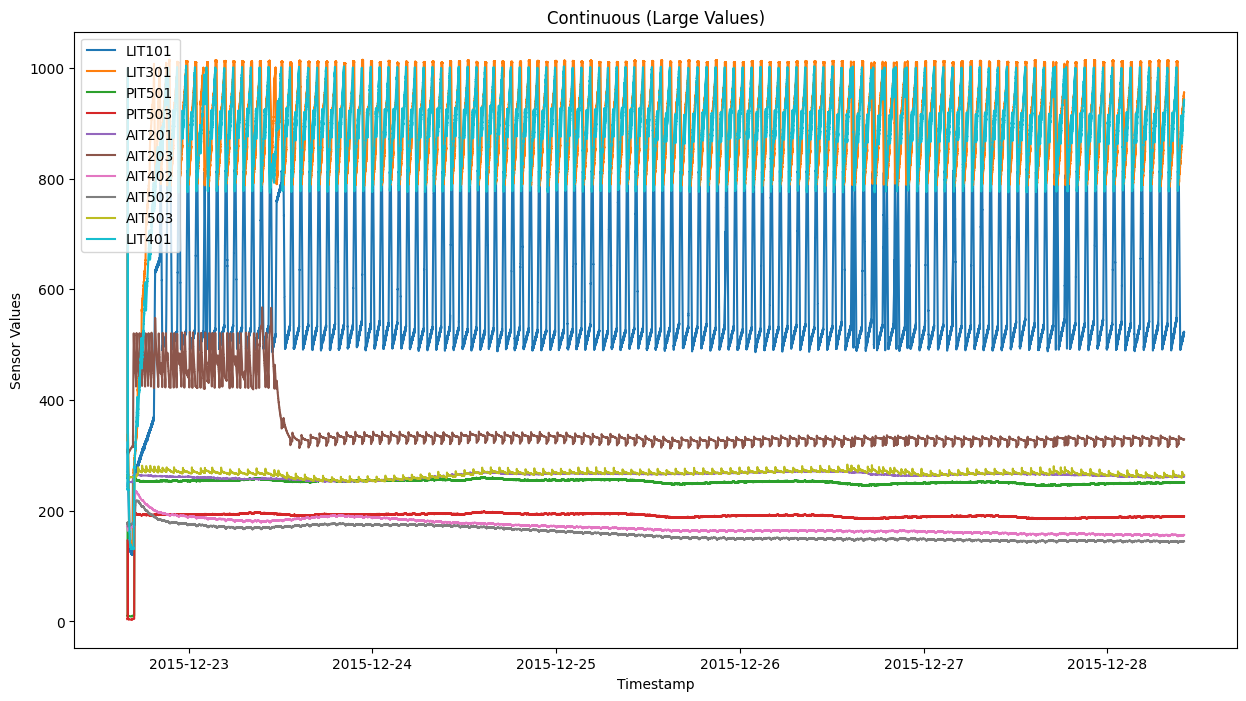

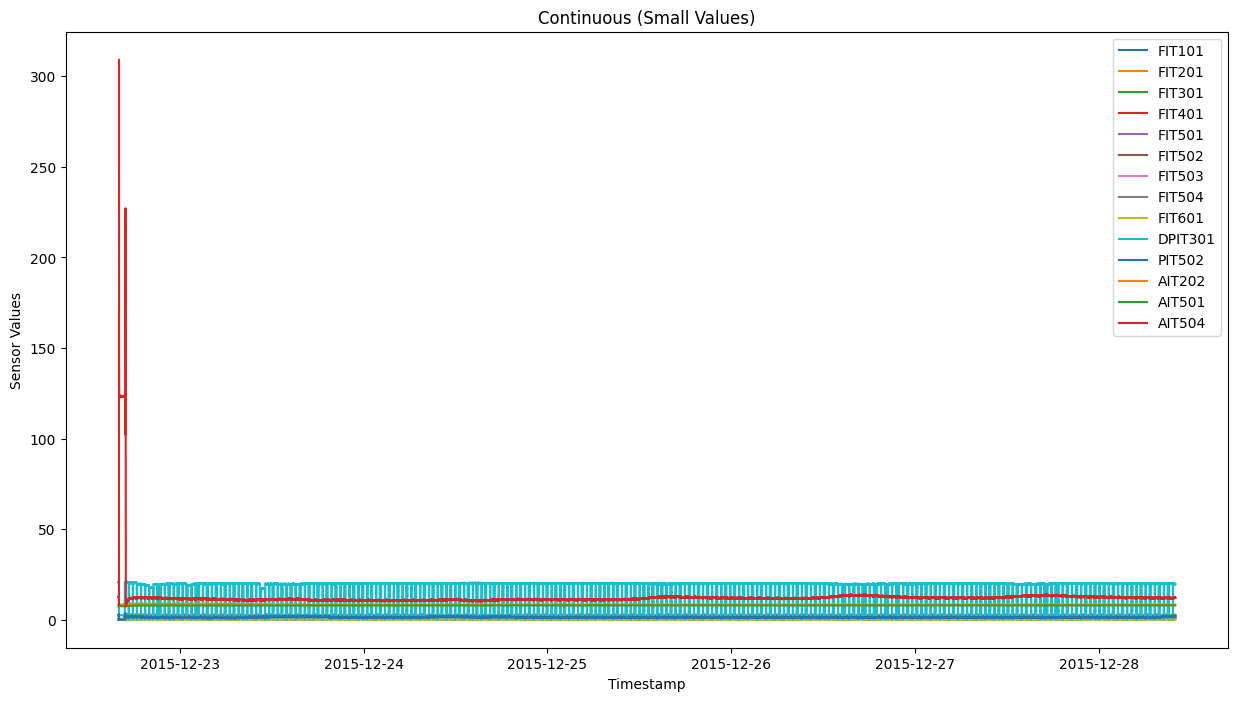

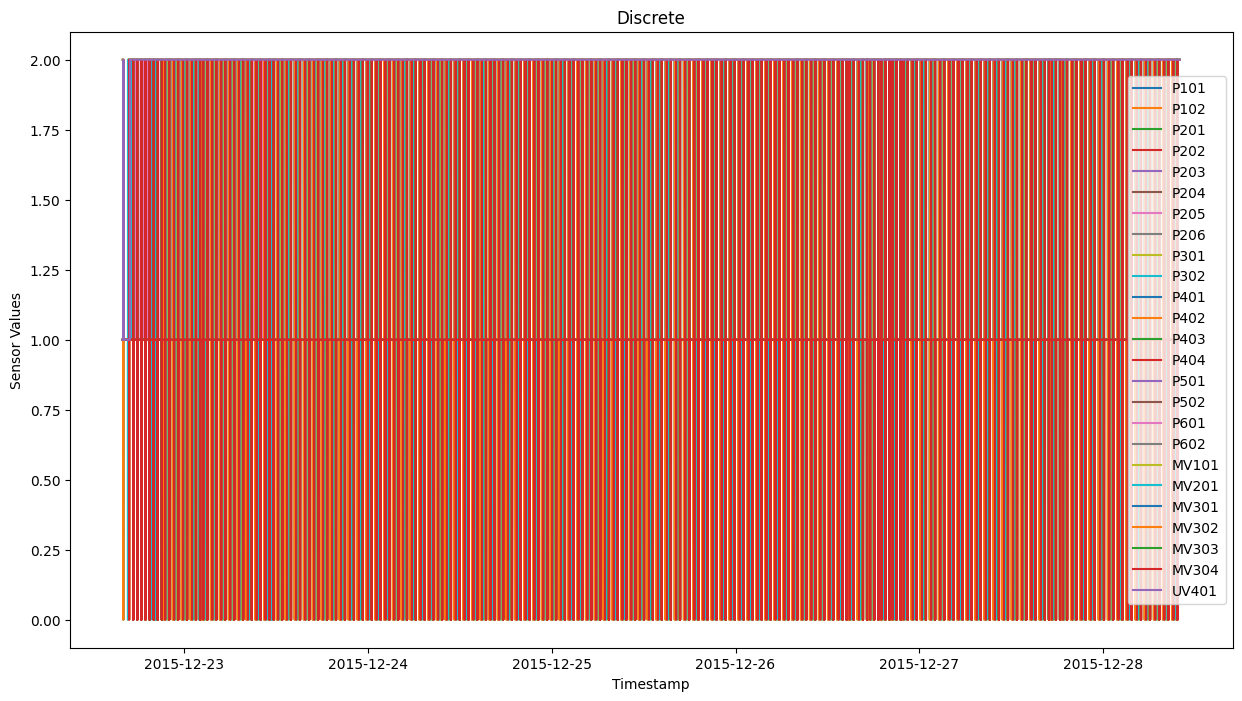

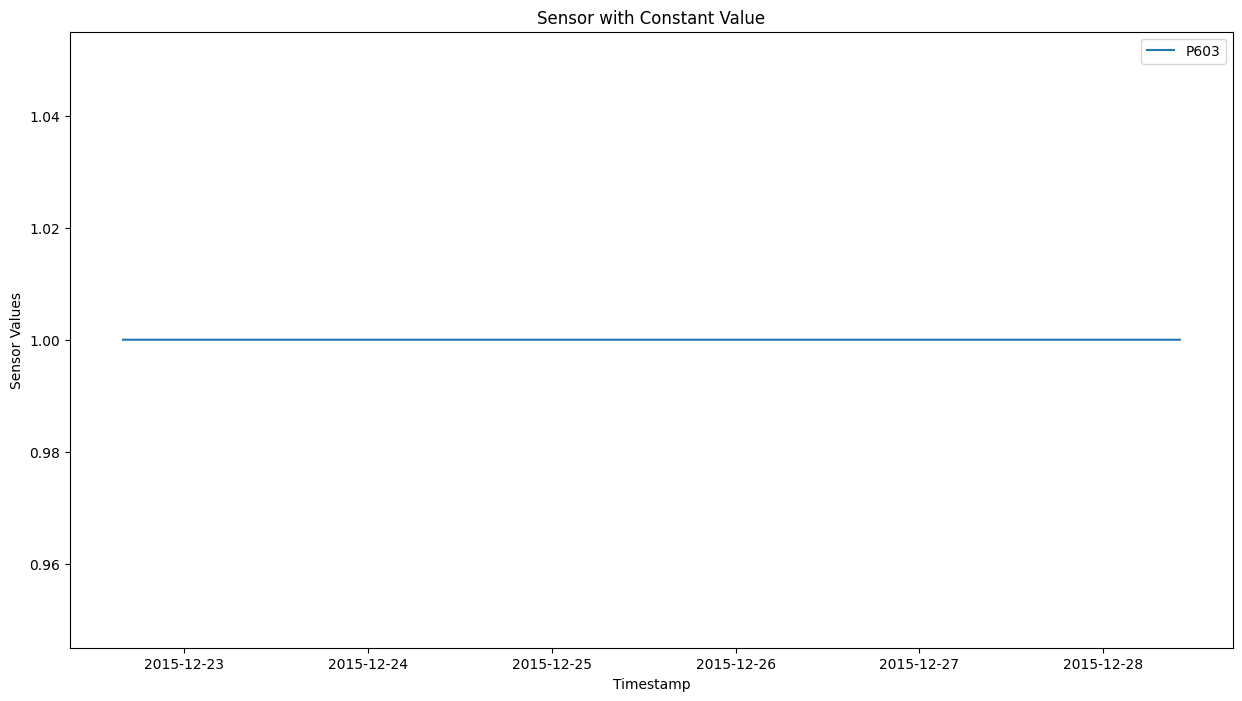

In [5]:
#Continuous (Large)
visualize_sensor_data(train_data, sensors=['LIT101', 'LIT301', 'PIT501', 'PIT503', 'AIT201', 'AIT203', 'AIT402', 'AIT502', 'AIT503', 'LIT401'],
                        title="Continuous (Large Values)")

#Continuous (Small)
visualize_sensor_data(train_data, sensors=['FIT101', 'FIT201', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'FIT601', 'DPIT301', 'PIT502', 'AIT202', 'AIT501', 'AIT504'],
                        title="Continuous (Small Values)")

#Discrete
visualize_sensor_data(train_data, sensors=['P101', 'P102', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'P501', 'P502', 'P601', 'P602',
                        'MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304', 'UV401'],
                        title="Discrete")

#Constant
visualize_sensor_data(train_data, sensors=['P603'], title="Sensor with Constant Value")

DTW-based anomaly detection – (15 points)  
 
Choose one signal that displays interesting temporal behavior. Build a set of 
representative sliding windows from the training data. This can be all data points, but to 
lower the run-time you can consider taking a subset. Plot the distances (sometimes 
called residual) of the train and test data points of this signal to their closest 
representative window (excluding overlapping ones). What kind of anomalies do you 
expect to detect using DTW distances in this manner?  
 
Experiment with using different sliding window sizes and jumps (sometimes called 
stride). Set these in such a way that you expect to detect anomalies with a low number of 
false alarms and such that the run-time is not too large. Show your analysis and explain 
your expectation. 

In [28]:
def normalize_data(sig):
    mean = sig.mean()
    sd = sig.std()
    return sig.apply(lambda x: (x-mean)/sd)

In [86]:
# Creates sliding windows from an array with a given size and jump
def build_windows(data, windowSize, jump):
    amountOfWindows = np.floor((len(data)-windowSize) / jump)
    windows = np.zeros(shape=(int(amountOfWindows),windowSize))
    # print("amount of windows, windowSize and jump:", int(amountOfWindows), ", ", windowSize, ", ", jump)
    for i in range(int(amountOfWindows)):
        for j in range(windowSize):
            # print("Window index:", i, ",", j)
            # print("Data Index:", j + i * jump)
            windows[i,j] = data[j + i * jump]
    return windows

In [129]:
def get_dtw_distance(model, test):
  matrix = np.zeros(shape=(len(model), len(test)))
  for i in range(len(model)):
    for j in range(len(test)):
      matrix[i, j] = (model[i] - test[j]) ** 2
  x = 0
  y = 0
  cost = matrix[0,0]
  # print(matrix)
  while x != len(model)-1 or y != len(test)-1:
    right = float('inf')
    down = float('inf')
    diagonal = float('inf')

    if x != len(model)-1 and y != len(test)-1:
        diagonal = matrix[x+1,y+1]
    if x != len(model)-1:
        right = matrix[x+1,y]
    if y != len(test)-1:
        down = matrix[x, y+1]

    min = np.min([right, down, diagonal])
    if right == min and x != len(model)-1:
      # print("right")
      x += 1
    elif down == min and y != len(test)-1:
      # print("down")
      y += 1
    elif diagonal == min:
      # print("diagonal")
      x += 1
      y += 1
    cost += min
    # print("Cost at", x, y, ":", cost)
  # print("Final cost", cost)
  return np.sqrt(cost)

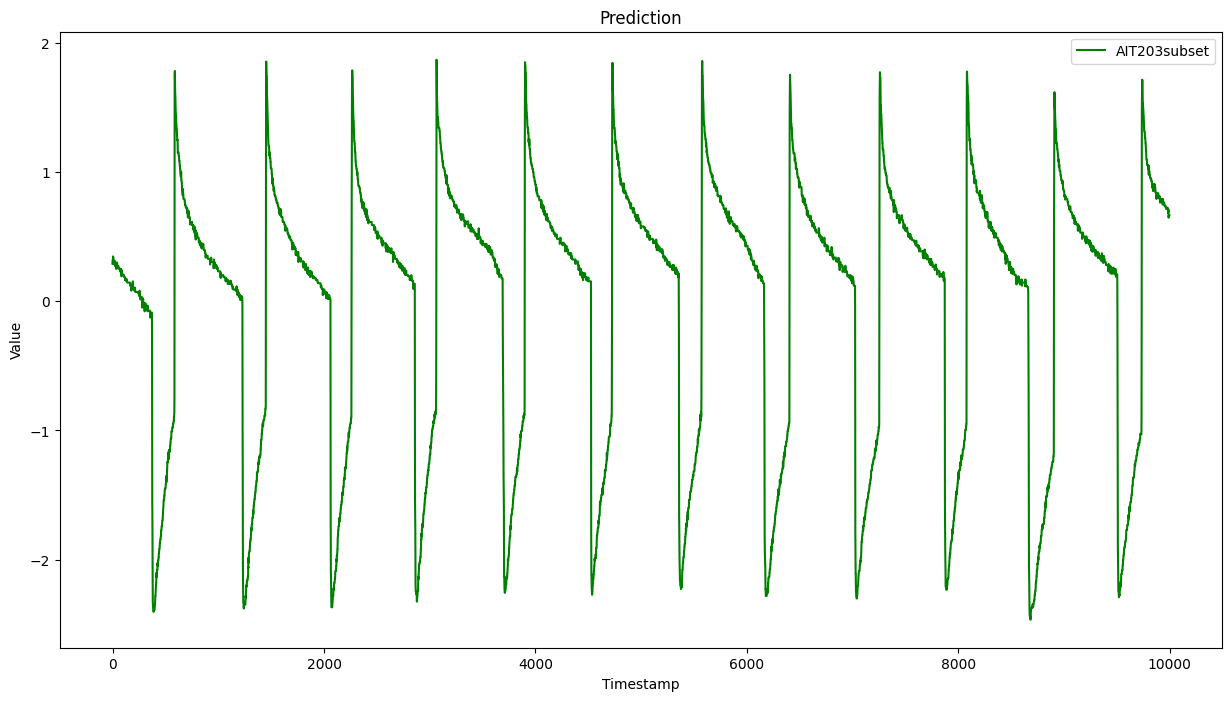

In [139]:
# Graph of subset to build windows on

start = 100000
end = 150000
sample = 10000
signal = "AIT203"
sample_train_data = normalize_data(train_data[signal][start:end]).sample(sample).sort_index().tolist()
sample_test_data = normalize_data(test_data[signal]).sample(sample).sort_index().tolist()
plt.figure(figsize=(15, 8))
plt.plot(range(len(sample_train_data)), sample_train_data, c='g', label=signal + "subset")
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title("Prediction")
plt.legend()
plt.show()

In [140]:
# Normalize, then sample the data and build sliding windows
train_windows = build_windows(sample_train_data, 2000, 2000)
test_windows = build_windows(sample_test_data, 100, 20)
distances = np.zeros(shape=(len(train_windows), len(test_windows)))
for i in range(len(train_windows)):
    for j in range(len(test_windows)):
        distance = get_dtw_distance(train_windows[i], test_windows[j])
        print(i, j, distance)
        distances[i,j] = distance
print("mean", distances.mean())
print("sd", distances.std())

0 0 46.882743182113735
0 1 41.06952448611492
0 2 52.721487303385445
0 3 48.74296253116653
0 4 40.93760883988802
0 5 48.297642694624486
0 6 41.335069466978105
0 7 51.18725378687349
0 8 49.09506886462272
0 9 41.09047649780935
0 10 49.358852794713926
0 11 48.13156439839901
0 12 46.6622385474431
0 13 40.82263922534082
0 14 47.32840633741862
0 15 46.60378361293672
0 16 45.95413869877505
0 17 40.70252824993245
0 18 50.81374703913889
0 19 48.51742711303774
0 20 48.043228390369165
0 21 48.28478812016653
0 22 40.823124589622985
0 23 49.88512595699112
0 24 53.493010155911016
0 25 51.04743729368057
0 26 50.28689111452947
0 27 49.53714388114027
0 28 50.466155799528394
0 29 52.74185348753695
0 30 50.96006091281709
0 31 50.927316789216505
0 32 49.849781519860294
0 33 41.048484848521404
0 34 43.810707353583744
0 35 53.574385348079396
0 36 52.19540272456568
0 37 51.51704054534897
0 38 50.367380961191834
0 39 41.0552066926099
0 40 40.42320109565734
0 41 53.92681282419741
0 42 52.26114275379838
0 43 51.

KeyboardInterrupt: 

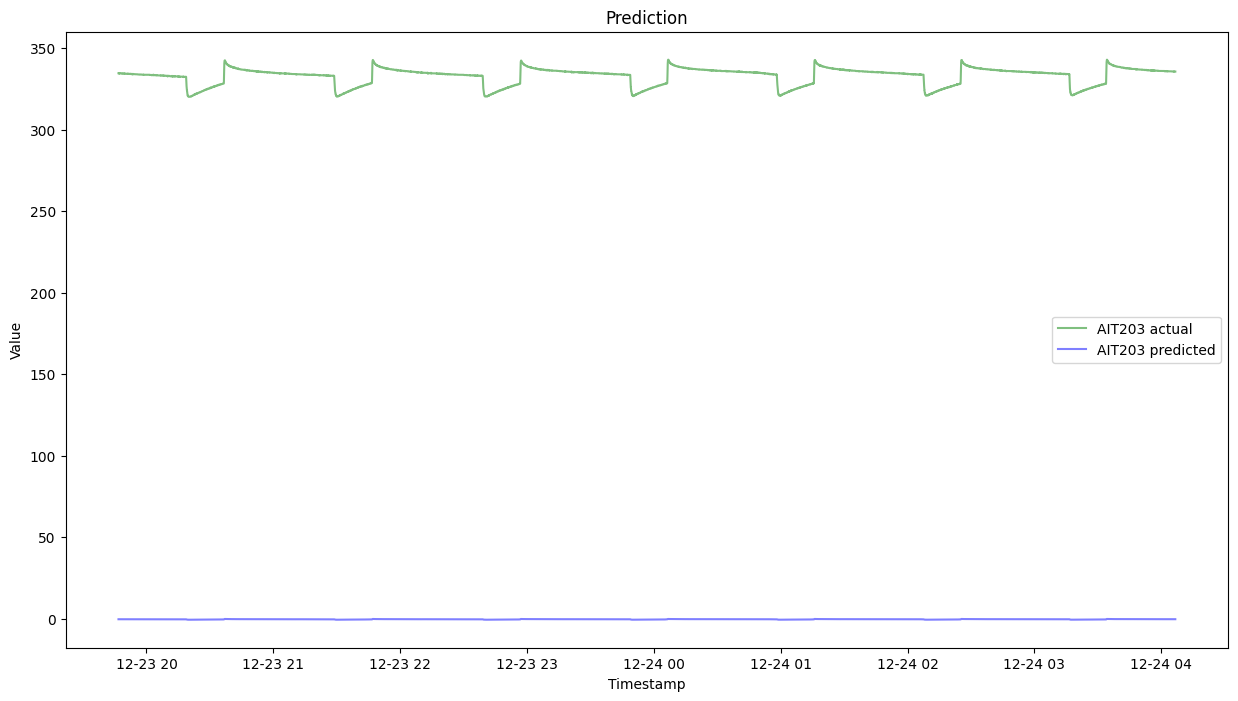

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(train_data['Timestamp'][x[0]:x[1]], train_data[signal][x[0]:x[1]], c='g', label=signal + " actual", alpha=0.5)
plt.plot(train_data['Timestamp'][x[0]:x[1]], y, label=signal + " predicted", c='b', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title("Prediction")
plt.legend()
plt.show()

PCA-based anomaly detection – (15 points)  
 
Perform PCA-based anomaly detection on the signal multivariate data points (do not 
take sequential context into account). You compute PCA to the train data, and apply it to 
both the train and test data. Plot the distance (residual, your choice of distance function) 
between the original and reconstructed data points. Do you see large abnormalities in 
the training data? Can you explain why these occur? It is best to remove such 
abnormalities from the training data since you only want to model normal behavior. 
Describe the kind of anomalies you expect to detect using PCA. 
 
Plot the PCA residuals for different number of components on the training data as one 
signal.  Choose the number of components based on the residuals and detected 
anomalies. Aim to set it such that you expect a small number of false alarms while still 
able to detect anomalies. Show your analysis and explain your expectation.